In [14]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [15]:
### Set time from to a certain number of years
years = 20

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 252*years)

### Create a list of tickers
tickers = ['RELIANCE.NS','TATAMOTORS.NS','SBIN.NS','INFY.NS','SUNPHARMA.NS']

In [16]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

            RELIANCE.NS  TATAMOTORS.NS     SBIN.NS      INFY.NS  SUNPHARMA.NS
Date                                                                         
2010-07-29   416.720917     160.100113  214.216690   265.046722    161.580658
2010-07-30   416.514618     156.340973  216.802261   260.860260    160.568375
2010-08-02   418.535980     156.525711  224.030777   261.660095    161.276474
2010-08-03   423.981476     155.500504  225.260742   260.476685    162.452209
2010-08-04   419.154846     155.989990  224.793060   268.915100    161.449020
...                 ...            ...         ...          ...           ...
2024-05-09  2788.250000    1030.300049  819.799988  1439.550049   1494.650024
2024-05-10  2814.850098    1046.650024  817.349976  1424.900024   1506.550049
2024-05-13  2805.399902     959.750000  808.799988  1423.449951   1525.050049
2024-05-14  2840.149902     964.650024  818.200012  1424.699951   1545.250000
2024-05-15  2832.550049     947.299988  820.299988  1419.949951 

In [17]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

            RELIANCE.NS  TATAMOTORS.NS   SBIN.NS   INFY.NS  SUNPHARMA.NS
Date                                                                    
2010-07-30    -0.000495      -0.023760  0.011998 -0.015921     -0.006285
2010-08-02     0.004841       0.001181  0.032798  0.003061      0.004400
2010-08-03     0.012927      -0.006571  0.005475 -0.004533      0.007264
2010-08-04    -0.011449       0.003143 -0.002078  0.031882     -0.006194
2010-08-05    -0.008897       0.019409  0.019291 -0.001828     -0.008443
...                 ...            ...       ...       ...           ...
2024-05-09    -0.017368       0.017823  0.011039  0.008546     -0.017969
2024-05-10     0.009495       0.015745 -0.002993 -0.010229      0.007930
2024-05-13    -0.003363      -0.086677 -0.010516 -0.001018      0.012205
2024-05-14     0.012311       0.005093  0.011555  0.000878      0.013158
2024-05-15    -0.002679      -0.018150  0.002563 -0.003340     -0.011619

[3401 rows x 5 columns]


In [18]:
### Create a function that will be used to calculate portfolio expected return
#We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [19]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

               RELIANCE.NS  TATAMOTORS.NS   SBIN.NS   INFY.NS  SUNPHARMA.NS
RELIANCE.NS       0.000302       0.000164  0.000142  0.000071      0.000076
TATAMOTORS.NS     0.000164       0.000660  0.000229  0.000101      0.000112
SBIN.NS           0.000142       0.000229  0.000440  0.000063      0.000074
INFY.NS           0.000071       0.000101  0.000063  0.000305      0.000054
SUNPHARMA.NS      0.000076       0.000112  0.000074  0.000054      0.000327


In [20]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [33]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 21

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [34]:
### Run 30000 simulations
simulations = 30000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [35]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

126110.80390087178


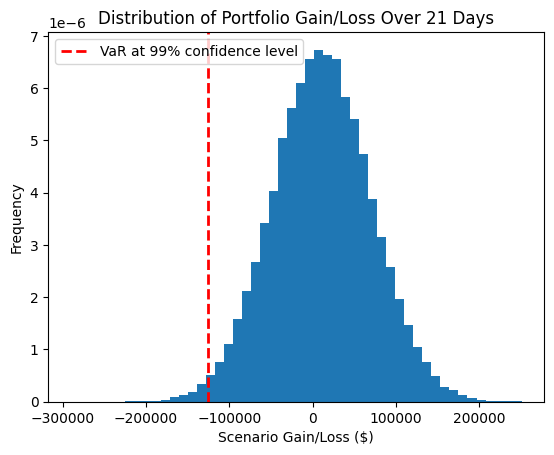

In [36]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()